Methods of Machine Learning and Intellectual Analysis of Data (Learning course) \
Bohdan Pavlyshenko (https://www.linkedin.com/in/bpavlyshenko/) \
Youtube video: https://www.youtube.com/watch?v=rVu4surrhbg&list=PLMQt7tnruMvF1jetHNUKjMtHKSp78H2bb&index=19

# Cats vs Dogs Classification (Pytorch, VGG16)

Used resources: \
https://www.kaggle.com/code/bootiu/dog-vs-cat-transfer-learning-vgg16-by-pytorch \
https://www.kaggle.com/code/alpaca0984/dog-vs-cat-with-pytorch \
https://www.kaggle.com/code/douglas426/pytorch-cnn-train-cat-vs-dog-acc-reach-95 \
https://www.kaggle.com/code/fareselmenshawii/introdution-to-transfer-learning \
https://www.doczamora.com/cats-vs-dogs-binary-classifier-with-pytorch-cnn \
https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/data \
https://medium.com/predict/using-pytorch-for-kaggles-famous-dogs-vs-cats-challenge-part-1-preprocessing-and-training-407017e1a10c

In [1]:
import copy
import glob
import multiprocessing
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [2]:
epochs = 5
num_classes = 2
batch_size = 64

In [3]:
def extract_class_from(path):
    file = path.split('/')[-1]
    return file.split('.')[0]


class CatDogDataset(Dataset):

    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.file_list[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)

        label_category = extract_class_from(img_name)
        label = 1 if label_category == 'dog' else 0

        return image, label


In [8]:
from google.colab import drive
import glob
import os

drive.mount('/content/drive')

# Specify the folder path within your Drive
folder_path = '/content/drive/MyDrive/LNU/2 course/2 semester/Data processing systems/jupyter_notebooks_data/data/dogsvscats/'
all_files = glob.glob(os.path.join(folder_path, '*.jpg'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
len(all_files)

964

In [10]:
sample_size = min(10000, len(all_files))
files_sample = random.sample(all_files, sample_size)

In [11]:
train_list, test_list = train_test_split(files_sample, random_state=42)

In [12]:
len(train_list), len(test_list)

(723, 241)

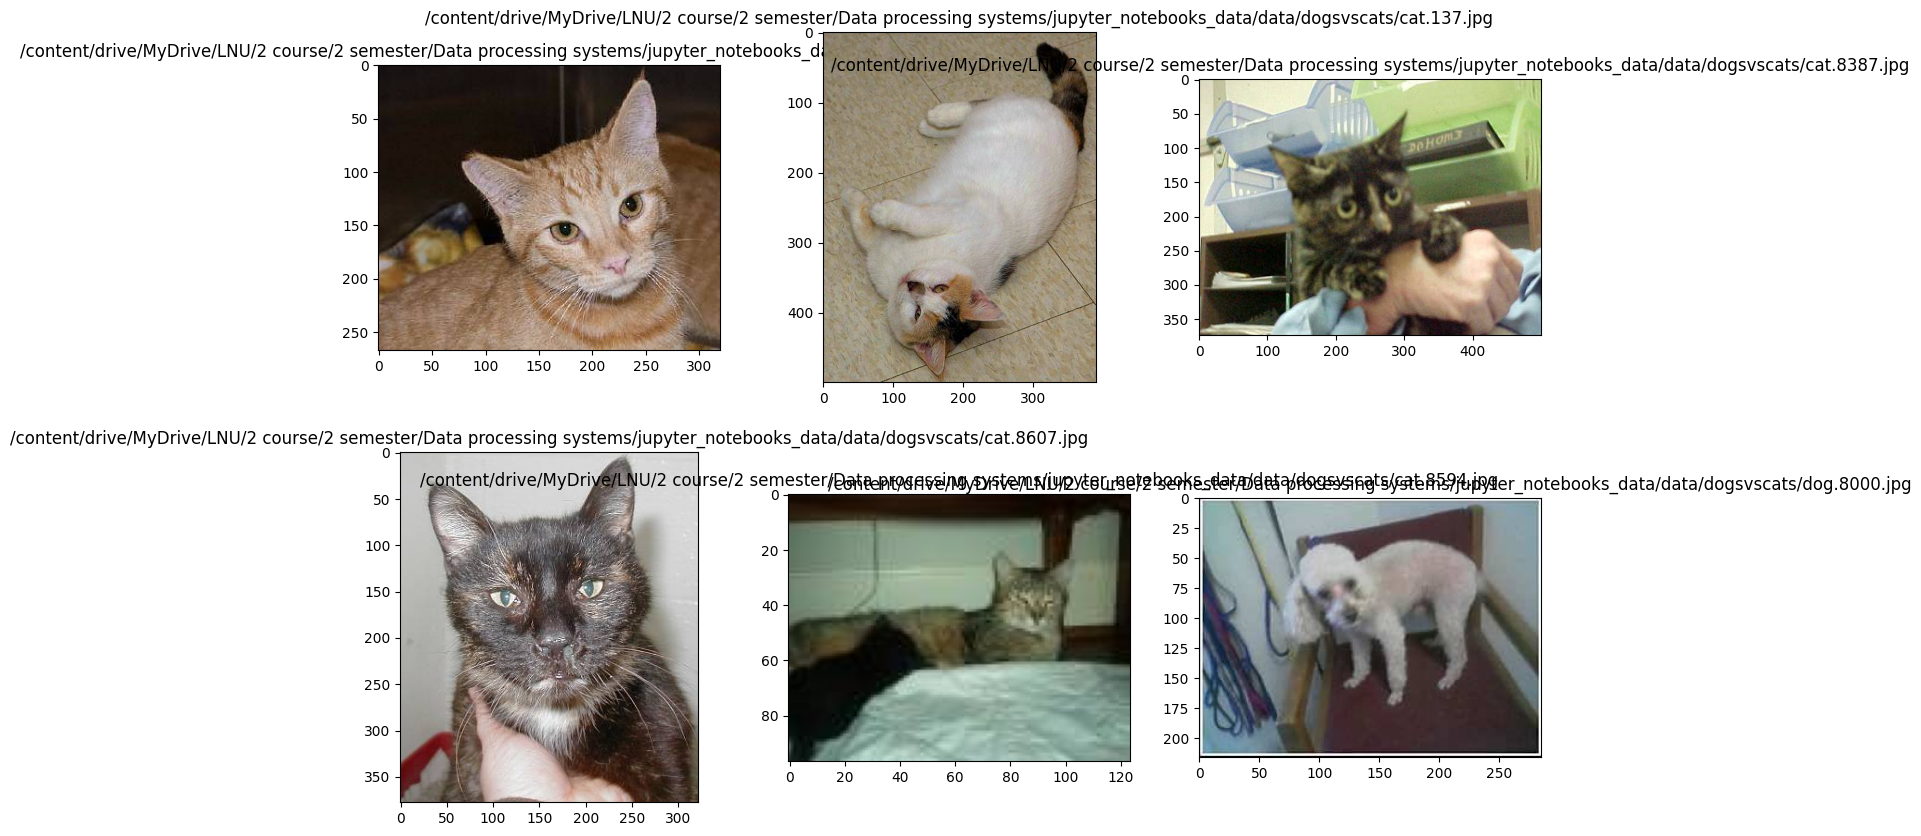

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(15, 10))
img_files=random.sample(all_files, 6)
for img_path, ax in zip(img_files, axes.ravel()):
    ax.set_title(img_path)
    ax.imshow(Image.open(img_path))

In [14]:
data_transforms_train = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
data_transforms_test = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [15]:
train_dataset =  CatDogDataset(train_list, transform=data_transforms_train)
test_dataset = CatDogDataset(test_list, transform=data_transforms_test)

train_dl =  DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [17]:
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096, num_classes)
model=model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 83.5MB/s]


In [18]:
params_to_update = []
for name, param in model.named_parameters():
    if (param.requires_grad == True):
        params_to_update.append(param)
        print(name)

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [19]:
len(params_to_update)

32

In [20]:
update_params_name = ['classifier.6.weight', 'classifier.6.bias']
params_to_update = []
for name, param in model.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

classifier.6.weight
classifier.6.bias


In [21]:
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.8)
criterion = nn.CrossEntropyLoss()

In [22]:
n_train=len(train_dataset)
n_test=len(test_dataset)

In [23]:
for epoch in range(epochs):
    model.train()

    train_loss = 0
    train_acc = 0
    test_loss = 0
    test_acc = 0

    for inputs, labels in tqdm(train_dl):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, pred = torch.max(outputs, 1)
        train_loss += loss.item()
        train_acc += torch.sum(pred == labels.data).item()

    model.eval()
    with torch.no_grad():
        for inputs, labels in test_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, pred = torch.max(outputs, 1)
            test_loss += loss.item()
            test_acc += torch.sum(pred == labels.data).item()

    train_loss = np.round(train_loss / n_train, 5)
    train_acc =  np.round(train_acc / n_train , 5)
    test_loss = np.round(test_loss / n_test, 5)
    test_acc =  np.round(test_acc / n_test, 5)
    print(f'epoch:{epoch+1}, train_loss:{train_loss}, train_acc:{train_acc}, \
test_loss:{test_loss}, test_acc:{test_acc }')

  0%|          | 0/12 [00:00<?, ?it/s]

epoch:1, train_loss:0.00582, train_acc:0.85339, test_loss:0.00197, test_acc:0.97925


  0%|          | 0/12 [00:00<?, ?it/s]

epoch:2, train_loss:0.00183, train_acc:0.98202, test_loss:0.00127, test_acc:0.98755


  0%|          | 0/12 [00:00<?, ?it/s]

epoch:3, train_loss:0.00141, train_acc:0.97787, test_loss:0.00106, test_acc:0.98755


  0%|          | 0/12 [00:00<?, ?it/s]

epoch:4, train_loss:0.00129, train_acc:0.97925, test_loss:0.00093, test_acc:0.9917


  0%|          | 0/12 [00:00<?, ?it/s]

epoch:5, train_loss:0.00123, train_acc:0.98755, test_loss:0.00085, test_acc:0.98755


In [24]:
n_results=15

test_data_transform = data_transforms_test

labels = []
preds = []
i=0
model.eval()
with torch.no_grad():
    for test_path in test_list:
        i=i+1
        img = Image.open(test_path)
        img = test_data_transform(img)
        img = img.unsqueeze(0)
        img = img.to(device)
        outputs = model(img)
        pred = F.softmax(outputs, dim=1)[:, 1].tolist()
        pred='dog' if int(round(pred[0]))==1 else 'cat'
        label = extract_class_from(test_path)
        labels.append(label)
        preds.append(pred)

        fig = plt.figure()
        ax = fig.add_subplot()
        _=ax.imshow(Image.open(test_path))
        _=ax.set_title(f'label:{label}, pred:{pred}')

        if(i>n_results):
            break

Output hidden; open in https://colab.research.google.com to view.